# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Functions for One Touch Options](#p1)

# [2. Functions for No Touch Options](#p2)

# [3. Functions for Barrier Options](#p3)

# [4. Charts for Touches Price](#p4)

# [5. Charts for Barriers Price](#p5)

# [6. Charts for Touches Greeks](#p6)

# [7. Charts for Barriers Greeks](#p7)

In [1]:
import numpy as np
from enum import Enum
from scipy.stats import norm

from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go

import warnings

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

%matplotlib ipympl

In [2]:
class BarrierTypes(Enum):
    DOWN_AND_OUT_CALL = 1
    DOWN_AND_IN_CALL = 2
    UP_AND_OUT_CALL = 3
    UP_AND_IN_CALL = 4
    UP_AND_OUT_PUT = 5
    UP_AND_IN_PUT = 6
    DOWN_AND_OUT_PUT = 7
    DOWN_AND_IN_PUT = 8
    
class OneTouchTypes(Enum):
    UPSIDE_ONETOUCH_AT_EXPIRY = 1
    DOWNSIDE_ONETOUCH_AT_EXPIRY = 2
    
class NoTouchTypes(Enum):
    UPSIDE_NOTOUCH = 1
    DOWNSIDE_NOTOUCH = 2    
    
def N(x):
    return norm.cdf(x)

# <a id = "p1">1.</a>  <font color = "green"> Functions for One Touch Options </font>  [back to table of contents](#top)

In [3]:
def OneTouchPrice(S0, r, q, h, vol, T, oneTouchType):

    texp = max(T, 1e-6)
    sqrtT = np.sqrt(texp)
    s = S0    
    sigmaRootT = vol * sqrtT
    v2 = vol * vol
    mu = r - q
    df = np.exp(-r * texp)
    dq = np.exp(-q * texp)
    
    if oneTouchType == OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY and s <= h:
        return df
    elif oneTouchType == OneTouchTypes.UPSIDE_ONETOUCH_AT_EXPIRY and s >= h:
        return df
        
    if abs(vol) < 1e-5:
        vol = 1e-5

    x1 = (np.log(h / s) + (mu - v2 / 2.0)* texp) / sigmaRootT
    y1 = (np.log(h / s) - (mu - v2 / 2.0)* texp) / sigmaRootT
    
    hOverS = pow(h / s, (2.0*mu / v2) - 1.0)        
        
    if oneTouchType == OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY:    
        return df * ( hOverS * N(x1) + N(y1) )
    elif oneTouchType == OneTouchTypes.UPSIDE_ONETOUCH_AT_EXPIRY:
        return df * ( hOverS * N(-x1) + N(-y1) )
    else:
        raise Exception("Unknown oneTouchType " + str(oneTouchType))
       
def OneTouchDelta_fd(S0, r, q, h, vol, T, oneTouchType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    p0 = OneTouchPrice(S0, r, q, h, vol, T, oneTouchType)
    pup = OneTouchPrice(S0_up, r, q, h, vol, T, oneTouchType)    
    return (pup-p0)/epsilon
    
def OneTouchGamma_fd(S0, r, q, h, vol, T, oneTouchType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    S0_down = S0 - epsilon    
    p0 = OneTouchPrice(S0, r, q, h, vol, T, oneTouchType)
    pup = OneTouchPrice(S0_up, r, q, h, vol, T, oneTouchType)    
    pdown = OneTouchPrice(S0_down, r, q, h, vol, T, oneTouchType)    
    return (pup+pdown-2*p0)/(epsilon*epsilon)

def OneTouchVega_fd(S0, r, q, h, vol, T, oneTouchType):
    epsilon = 0.001
    vol_up = vol + epsilon    
    p0 = OneTouchPrice(S0, r, q, h, vol, T, oneTouchType)
    pup = OneTouchPrice(S0, r, q, h, vol_up, T, oneTouchType)    
    return (pup-p0)/epsilon

# <a id = "p2">2.</a>  <font color = "green"> Functions for No Touch Options </font>  [back to table of contents](#top)

In [4]:
def NoTouchPrice(S0, r, q, h, vol, T, noTouchType):
    texp = max(T, 1e-6)
    df = np.exp(-r * texp)
    
    if noTouchType == NoTouchTypes.UPSIDE_NOTOUCH:
        return df - OneTouchPrice(S0, r, q, h, vol, T, OneTouchTypes.UPSIDE_ONETOUCH_AT_EXPIRY)
    elif noTouchType == NoTouchTypes.DOWNSIDE_NOTOUCH:
        return df - OneTouchPrice(S0, r, q, h, vol, T, OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY)
    else:
        raise Exception("Unknown noTouchType " + str(noTouchType))
        
def NoTouchDelta_fd(S0, r, q, h, vol, T, noTouchType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    p0 = NoTouchPrice(S0, r, q, h, vol, T, noTouchType)
    pup = NoTouchPrice(S0_up, r, q, h, vol, T, noTouchType)    
    return (pup-p0)/epsilon
    
def NoTouchGamma_fd(S0, r, q, h, vol, T, noTouchType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    S0_down = S0 - epsilon    
    p0 = NoTouchPrice(S0, r, q, h, vol, T, noTouchType)
    pup = NoTouchPrice(S0_up, r, q, h, vol, T, noTouchType)    
    pdown = NoTouchPrice(S0_down, r, q, h, vol, T, noTouchType)    
    return (pup+pdown-2*p0)/(epsilon*epsilon)

def NoTouchVega_fd(S0, r, q, h, vol, T, noTouchType):
    epsilon = 0.001
    vol_up = vol + epsilon    
    p0 = NoTouchPrice(S0, r, q, h, vol, T, noTouchType)
    pup = NoTouchPrice(S0, r, q, h, vol_up, T, noTouchType)    
    return (pup-p0)/epsilon

# <a id = "p3">3.</a>  <font color = "green"> Functions for Barrier Options </font>  [back to table of contents](#top)

In [5]:
def BarrierOptionPrice(S0, r, q, k, h, vol, T, barrierType):

    texp = max(T, 1e-6)

    lnS0k = np.log(S0 / k)
    sqrtT = np.sqrt(texp)

    s = S0
    
    sigmaRootT = vol * sqrtT
    v2 = vol * vol
    mu = r - q
    d1 = (lnS0k + (mu + v2 / 2.0) * texp) / sigmaRootT
    d2 = (lnS0k + (mu - v2 / 2.0) * texp) / sigmaRootT
    df = np.exp(-r * texp)
    dq = np.exp(-q * texp)

    c = s * dq * N(d1) - k * df * N(d2)
    p = k * df * N(-d2) - s * dq * N(-d1)

    if barrierType == BarrierTypes.DOWN_AND_OUT_CALL and s <= h:
        return 0.0
    elif barrierType == BarrierTypes.UP_AND_OUT_CALL and s >= h:
        return 0.0
    elif barrierType == BarrierTypes.UP_AND_OUT_PUT and s >= h:
        return 0.0
    elif barrierType == BarrierTypes.DOWN_AND_OUT_PUT and s <= h:
        return 0.0
    elif barrierType == BarrierTypes.DOWN_AND_IN_CALL and s <= h:
        return c
    elif barrierType == BarrierTypes.UP_AND_IN_CALL and s >= h:
        return c
    elif barrierType == BarrierTypes.UP_AND_IN_PUT and s >= h:
        return p
    elif barrierType == BarrierTypes.DOWN_AND_IN_PUT and s <= h:
        return p

    if abs(vol) < 1e-5:
        vol = 1e-5

    l = (mu + v2 / 2.0) / v2
    y = np.log(h * h / (s * k)) / sigmaRootT + l * sigmaRootT
    x1 = np.log(s / h) / sigmaRootT + l * sigmaRootT
    y1 = np.log(h / s) / sigmaRootT + l * sigmaRootT
    hOverS = h / s

    if barrierType == BarrierTypes.DOWN_AND_OUT_CALL:
        if h >= k:
            c_do = s * dq * N(x1) - k * df * N(x1 - sigmaRootT) \
                - s * dq * pow(hOverS, 2.0 * l) * N(y1) \
                + k * df * pow(hOverS, 2.0 * l - 2.0) * N(y1 - sigmaRootT)
            price = c_do
        else:
            c_di = s * dq * pow(hOverS, 2.0 * l) * N(y) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * N(y - sigmaRootT)
            price = c - c_di
    elif barrierType == BarrierTypes.DOWN_AND_IN_CALL:
        if h <= k:
            c_di = s * dq * pow(hOverS, 2.0 * l) * N(y) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * N(y - sigmaRootT)
            price = c_di
        else:
            c_do = s * dq * N(x1) \
                - k * df * N(x1 - sigmaRootT) \
                - s * dq * pow(hOverS, 2.0 * l) * N(y1) \
                + k * df * pow(hOverS, 2.0 * l - 2.0) * N(y1 - sigmaRootT)
            price = c - c_do
    elif barrierType == BarrierTypes.UP_AND_IN_CALL:
        if h >= k:
            c_ui = s * dq * N(x1) - k * df * N(x1 - sigmaRootT) \
                - s * dq * pow(hOverS, 2.0 * l) * (N(-y) - N(-y1)) \
                + k * df * pow(hOverS, 2.0 * l - 2.0) * (N(-y + sigmaRootT) - N(-y1 + sigmaRootT))
            price = c_ui
        else:
            price = c
    elif barrierType == BarrierTypes.UP_AND_OUT_CALL:
        if h > k:
            c_ui = s * dq * N(x1) - k * df * N(x1 - sigmaRootT) \
                 - s * dq * pow(hOverS, 2.0 * l) * (N(-y) - N(-y1)) \
                 + k * df * pow(hOverS, 2.0 * l - 2.0) * (N(-y + sigmaRootT) - N(-y1 + sigmaRootT))
            price = c - c_ui
        else:
            price = 0.0
    elif barrierType == BarrierTypes.UP_AND_IN_PUT:
        if h > k:
            p_ui = -s * dq * pow(hOverS, 2.0 * l) * N(-y) \
                + k * df * pow(hOverS, 2.0 * l - 2.0) * N(-y + sigmaRootT)
            price = p_ui
        else:
            p_uo = -s * dq * N(-x1) \
                + k * df * N(-x1 + sigmaRootT) \
                + s * dq * pow(hOverS, 2.0 * l) * N(-y1) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * N(-y1 + sigmaRootT)
            price = p - p_uo
    elif barrierType == BarrierTypes.UP_AND_OUT_PUT:
        if h >= k:
            p_ui = -s * dq * pow(hOverS, 2.0 * l) * N(-y) \
                + k * df * pow(hOverS, 2.0 * l - 2.0) * N(-y + sigmaRootT)
            price = p - p_ui
        else:
            p_uo = -s * dq * N(-x1) \
                + k * df * N(-x1 + sigmaRootT) \
                + s * dq * pow(hOverS, 2.0 * l) * N(-y1) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * N(-y1 + sigmaRootT)
            price = p_uo
    elif barrierType == BarrierTypes.DOWN_AND_OUT_PUT:
        if h >= k:
            price = 0.0
        else:
            p_di = -s * dq * N(-x1) \
                + k * df * N(-x1 + sigmaRootT) \
                + s * dq * pow(hOverS, 2.0 * l) * (N(y) - N(y1)) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * (N(y - sigmaRootT) - N(y1 - sigmaRootT))
            price = p - p_di
    elif barrierType == BarrierTypes.DOWN_AND_IN_PUT:
        if h >= k:
            price = p
        else:
            p_di = -s * dq * N(-x1) \
                + k * df * N(-x1 + sigmaRootT) \
                + s * dq * pow(hOverS, 2.0 * l) * (N(y) - N(y1)) \
                - k * df * pow(hOverS, 2.0 * l - 2.0) * (N(y - sigmaRootT) - N(y1 - sigmaRootT))
            price = p_di
    else:
        raise Exception("Unknown barrier option type." + str(barrierType))

    return price


def BarrierOptionDelta_fd(S0, r, q, k, h, vol, T, barrierType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    p0 = BarrierOptionPrice(S0, r, q, k, h, vol, T, barrierType)
    pup = BarrierOptionPrice(S0_up, r, q, k, h, vol, T, barrierType)    
    return (pup-p0)/epsilon
    
def BarrierOptionGamma_fd(S0, r, q, k, h, vol, T, barrierType):
    epsilon = 0.001
    S0_up = S0 + epsilon    
    S0_down = S0 - epsilon    
    p0 = BarrierOptionPrice(S0, r, q, k, h, vol, T, barrierType)
    pup = BarrierOptionPrice(S0_up, r, q, k, h, vol, T, barrierType)    
    pdown = BarrierOptionPrice(S0_down, r, q, k, h, vol, T, barrierType)    
    return (pup+pdown-2*p0)/(epsilon*epsilon)

def BarrierOptionVega_fd(S0, r, q, k, h, vol, T, barrierType):
    epsilon = 0.001
    vol_up = vol + epsilon    
    p0 = BarrierOptionPrice(S0, r, q, k, h, vol, T, barrierType)
    pup = BarrierOptionPrice(S0, r, q, k, h, vol_up, T, barrierType)    
    return (pup-p0)/epsilon

# <a id = "p4">4.</a>  <font color = "green"> Charts for Touches Price</font>  [back to table of contents](#top)

In [6]:
# Use this ONLY if the options model parameters are S0, r, q, h, vol, T, oneTouchType

def OTPricesandGreeks(model, oneTouchType):
    # Initial parameters
    r = 0
    q = 0
    h = 90
    vol = 0.20
    T = 1
    S0 = 100    
    
    axis_color = 'skyblue'

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(left=0.30, bottom=0.40)

    # Define the range for S0
    S0_range = np.linspace(1, 250, 250)
    prices = [model(S0, r, q, h, vol, T, oneTouchType) for S0 in S0_range]

    line, = ax.plot(S0_range, prices, linewidth=2, color='red')
    ax.set_xlim([0, 250])
    ax.set_ylim([min(min(prices) * 0.9,min(prices) * 1.1), max(prices) * 1.1])
    ax.set_xlabel('Underlying Price')
    ax.set_ylabel('Price/ Greek Value')
    ax.set_title(f"{oneTouchType} Value")

    # Slider definitions

    rf_slider_ax = fig.add_axes([0.25, 0.28, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.20, valinit=r)
    
    dividend_yield_slider_ax = fig.add_axes([0.25, 0.24, 0.65, 0.03], facecolor=axis_color)
    dividend_yield_slider = Slider(dividend_yield_slider_ax, 'Dividend Yield', 0.00, 0.20, valinit=q)
    
    sigma_slider_ax = fig.add_axes([0.25, 0.20, 0.65, 0.03], facecolor=axis_color)
    sigma_slider = Slider(sigma_slider_ax, 'Sigma', 0.1, 0.9, valinit=vol)
    
    # strike_slider_ax = fig.add_axes([0.25, 0.16, 0.65, 0.03], facecolor=axis_color)
    # strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=k)
    
    barrier_slider_ax = fig.add_axes([0.25, 0.16, 0.65, 0.03], facecolor=axis_color)
    barrier_slider = Slider(barrier_slider_ax, 'Barrier', 50, 150, valinit=h)
    
    time_slider_ax = fig.add_axes([0.25, 0.12, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T)

    def sliders_on_changed(val):
        #S_current = S_slider.val
        
        rf_current = rf_slider.val
        dividend_yield_current = dividend_yield_slider.val
        sigma_current = sigma_slider.val
        # strike_current = strike_slider.val
        barrier_current = barrier_slider.val
        T_current = time_slider.val

        prices = [model(S0, rf_current, dividend_yield_current, barrier_current, sigma_current, T_current, oneTouchType) for S0 in S0_range]
        line.set_ydata(prices)
        ax.set_ylim([min(min(prices) * 0.9,min(prices) * 1.1), max(prices) * 1.1])  # Adjust y-axis based on new data
        fig.canvas.draw_idle()

    #S_slider.on_changed(sliders_on_changed)
    rf_slider.on_changed(sliders_on_changed)
    dividend_yield_slider.on_changed(sliders_on_changed)
    sigma_slider.on_changed(sliders_on_changed)
    # strike_slider.on_changed(sliders_on_changed)
    barrier_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)

    # Reset button
    reset_button_ax = fig.add_axes([0.8, 0.01, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        #S_slider.reset()
        rf_slider.reset()
        dividend_yield_slider.reset()
        sigma_slider.reset()
        # strike_slider.reset()
        barrier_slider.reset()
        time_slider.reset()

    reset_button.on_clicked(reset_button_on_clicked)

    plt.show()

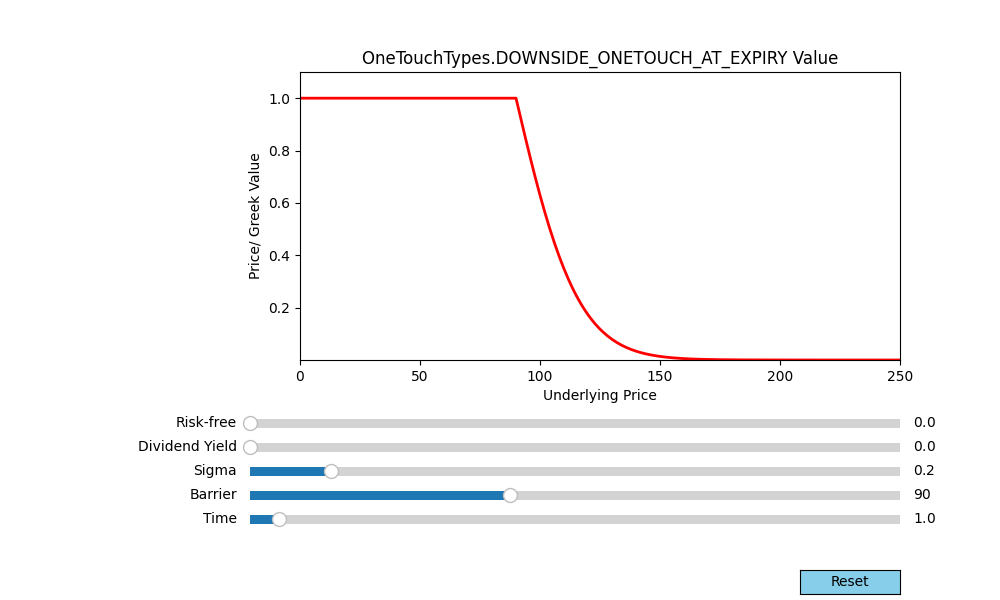

In [7]:
OTPricesandGreeks(OneTouchPrice, OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY)

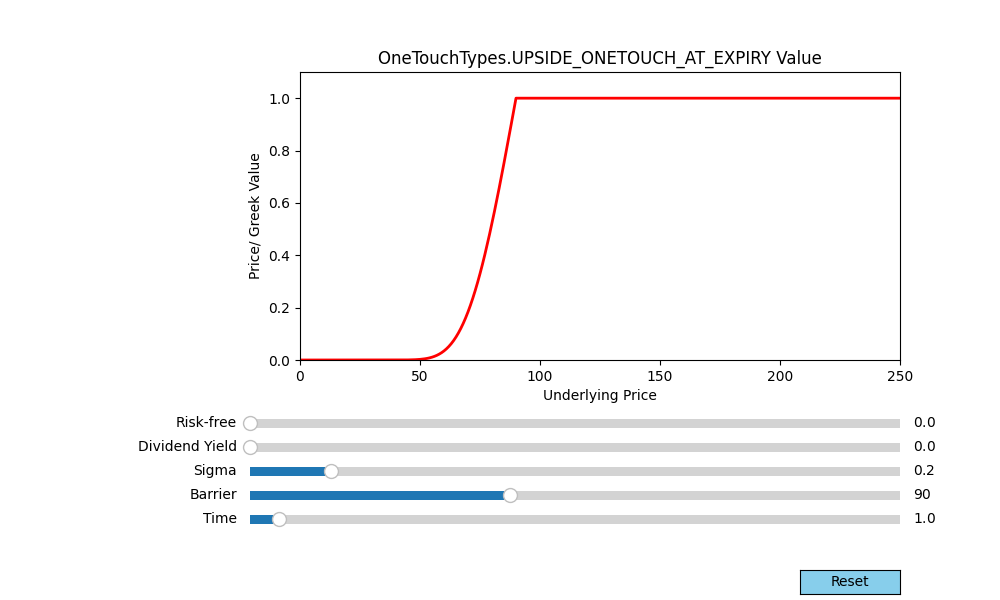

In [8]:
OTPricesandGreeks(OneTouchPrice, OneTouchTypes.UPSIDE_ONETOUCH_AT_EXPIRY)

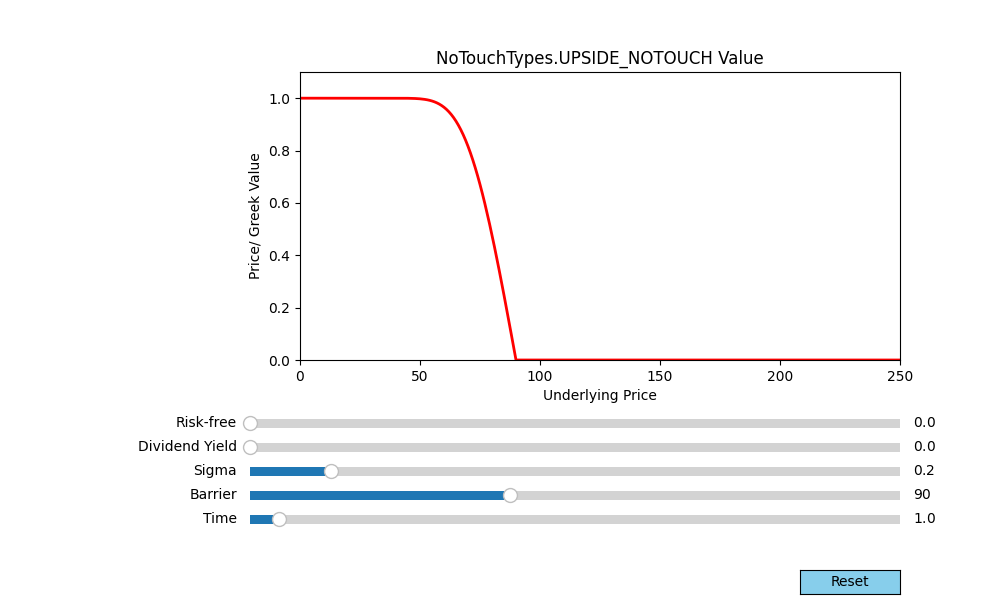

In [9]:
OTPricesandGreeks(NoTouchPrice, NoTouchTypes.UPSIDE_NOTOUCH)

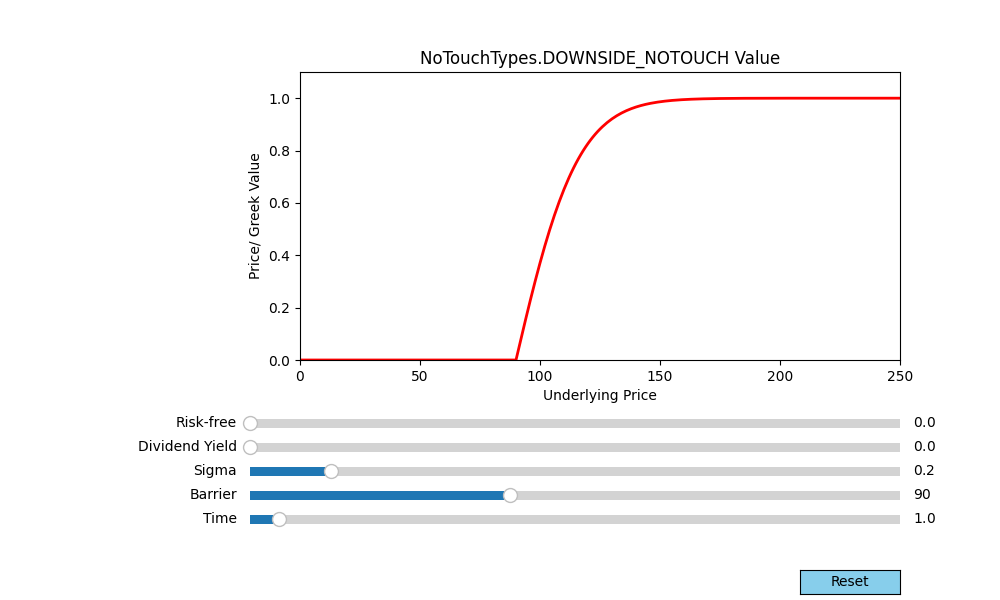

In [10]:
OTPricesandGreeks(NoTouchPrice, NoTouchTypes.DOWNSIDE_NOTOUCH)

# <a id = "p5">5.</a>  <font color = "green"> Charts for Barriers Price</font>  [back to table of contents](#top)

In [11]:
# Use this ONLY if the options model parameters are S0, r, q, k, h, vol, T, barrierType

def BarrierPricesandGreeks(model, barrierType):
    # Initial parameters
    r = 0
    q = 0
    k = 100
    h = 90
    vol = 0.20
    T = 1
    S0 = 100    
    
    axis_color = 'skyblue'

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(left=0.30, bottom=0.40)

    # Define the range for S0
    S0_range = np.linspace(1, 250, 250)
    prices = [model(S0, r, q, k, h, vol, T, barrierType) for S0 in S0_range]

    line, = ax.plot(S0_range, prices, linewidth=2, color='red')
    ax.set_xlim([0, 250])
    ax.set_ylim([min(min(prices) * 0.9,min(prices) * 1.1), max(prices) * 1.1])
    ax.set_xlabel('Underlying Price')
    ax.set_ylabel('Price/ Greek Value')
    ax.set_title(f"{barrierType} Value")

    # Slider definitions

    rf_slider_ax = fig.add_axes([0.25, 0.28, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.20, valinit=r)
    
    dividend_yield_slider_ax = fig.add_axes([0.25, 0.24, 0.65, 0.03], facecolor=axis_color)
    dividend_yield_slider = Slider(dividend_yield_slider_ax, 'Dividend Yield', 0.00, 0.20, valinit=q)
    
    sigma_slider_ax = fig.add_axes([0.25, 0.20, 0.65, 0.03], facecolor=axis_color)
    sigma_slider = Slider(sigma_slider_ax, 'Sigma', 0.1, 0.9, valinit=vol)
    
    strike_slider_ax = fig.add_axes([0.25, 0.16, 0.65, 0.03], facecolor=axis_color)
    strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=k)
    
    barrier_slider_ax = fig.add_axes([0.25, 0.12, 0.65, 0.03], facecolor=axis_color)
    barrier_slider = Slider(barrier_slider_ax, 'Barrier', 50, 150, valinit=h)
    
    time_slider_ax = fig.add_axes([0.25, 0.08, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T)

    def sliders_on_changed(val):
        #S_current = S_slider.val
        
        rf_current = rf_slider.val
        dividend_yield_current = dividend_yield_slider.val
        sigma_current = sigma_slider.val
        strike_current = strike_slider.val
        barrier_current = barrier_slider.val
        T_current = time_slider.val

        prices = [model(S0, rf_current, dividend_yield_current, strike_current, barrier_current, sigma_current, T_current, barrierType) for S0 in S0_range]
        line.set_ydata(prices)
        ax.set_ylim([min(min(prices) * 0.9,min(prices) * 1.1), max(prices) * 1.1])  # Adjust y-axis based on new data
        fig.canvas.draw_idle()

    #S_slider.on_changed(sliders_on_changed)
    rf_slider.on_changed(sliders_on_changed)
    dividend_yield_slider.on_changed(sliders_on_changed)
    sigma_slider.on_changed(sliders_on_changed)
    strike_slider.on_changed(sliders_on_changed)
    barrier_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)

    # Reset button
    reset_button_ax = fig.add_axes([0.8, 0.01, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        #S_slider.reset()
        rf_slider.reset()
        dividend_yield_slider.reset()
        sigma_slider.reset()
        strike_slider.reset()
        barrier_slider.reset()
        time_slider.reset()

    reset_button.on_clicked(reset_button_on_clicked)

    plt.show()

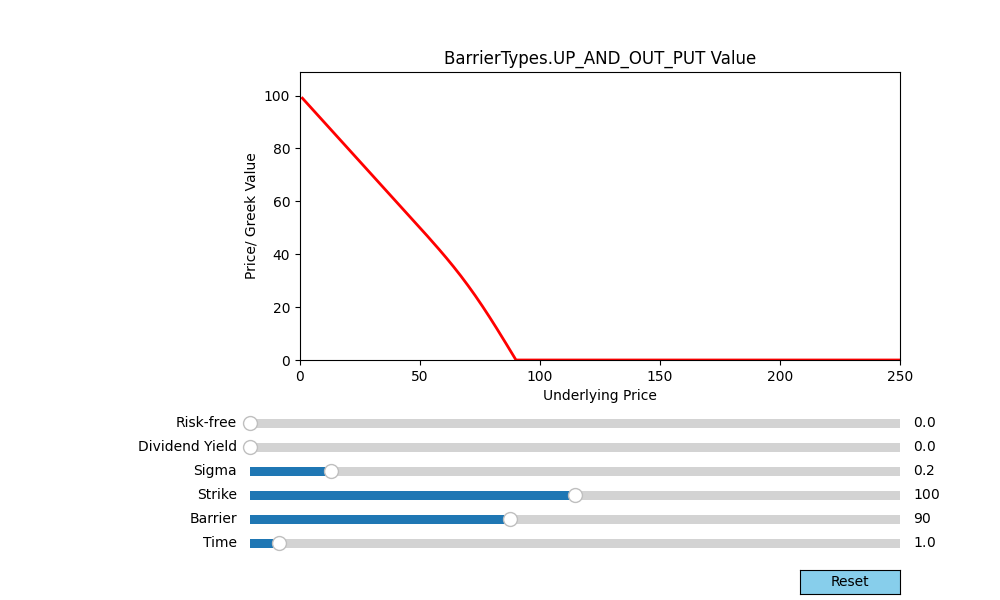

In [12]:
BarrierPricesandGreeks(BarrierOptionPrice, BarrierTypes.UP_AND_OUT_PUT)

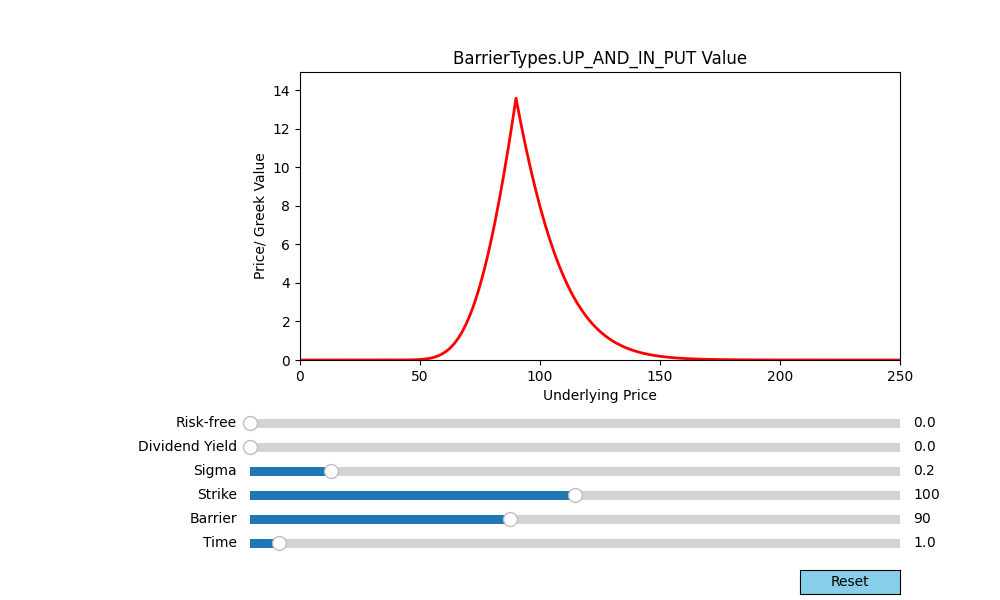

In [13]:
BarrierPricesandGreeks(BarrierOptionPrice, BarrierTypes.UP_AND_IN_PUT)

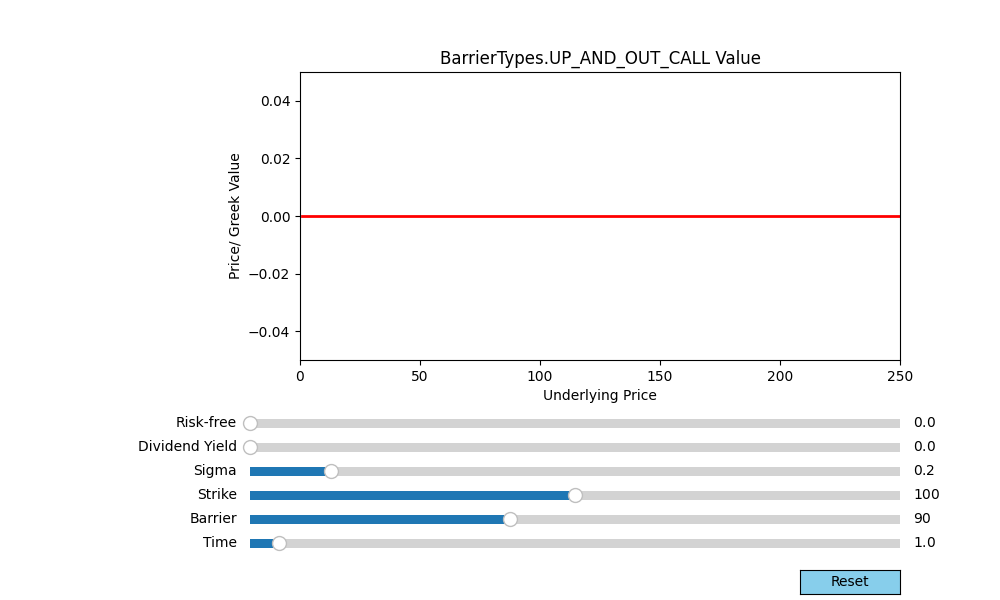

In [14]:
BarrierPricesandGreeks(BarrierOptionPrice, BarrierTypes.UP_AND_OUT_CALL)

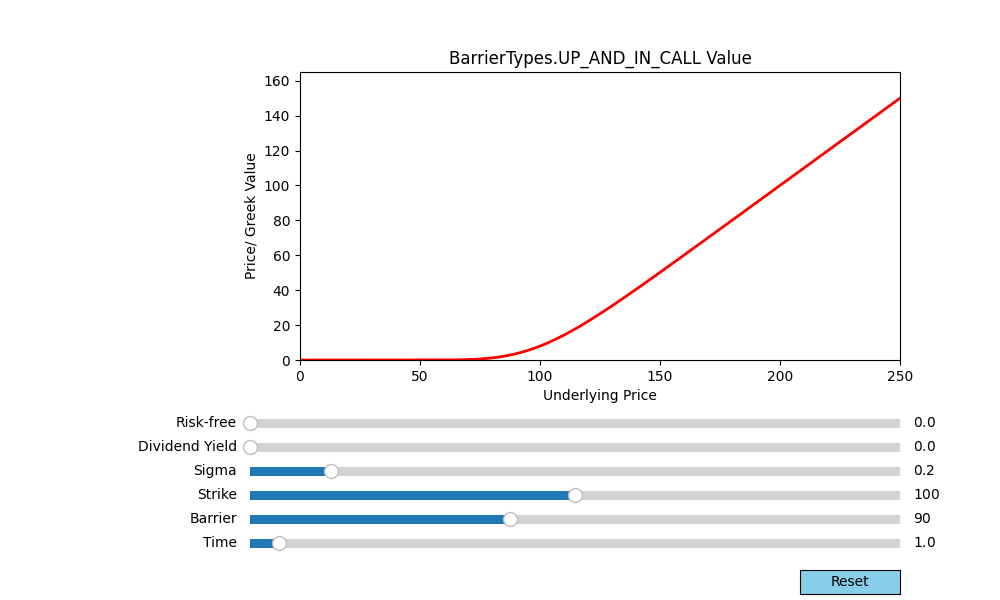

In [15]:
BarrierPricesandGreeks(BarrierOptionPrice, BarrierTypes.UP_AND_IN_CALL)

# <a id = "p6">6.</a>  <font color = "green"> Charts for Touches Greeks</font>  [back to table of contents](#top)

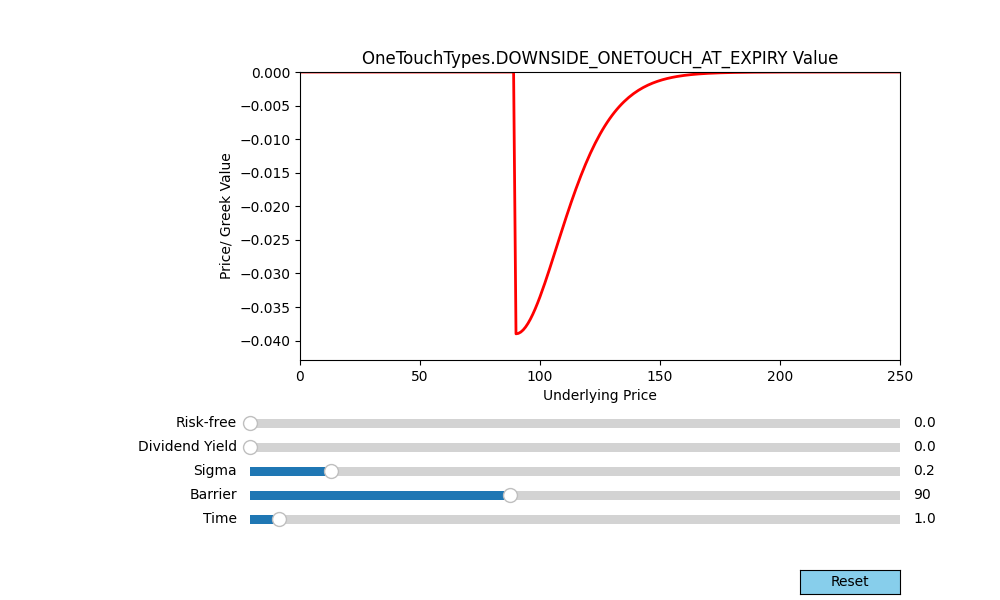

In [16]:
OTPricesandGreeks(OneTouchDelta_fd, OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY)

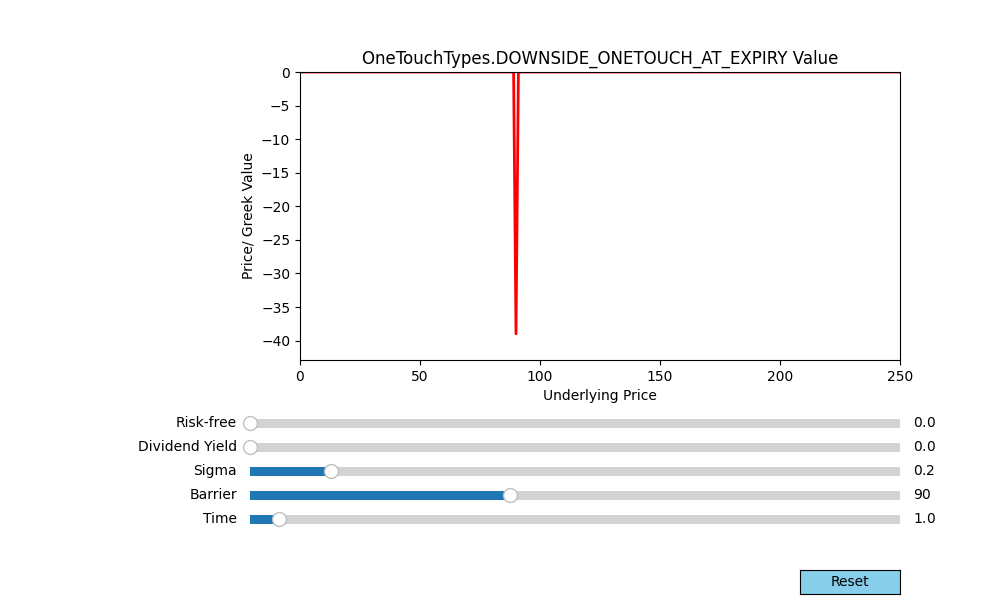

In [17]:
OTPricesandGreeks(OneTouchGamma_fd, OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY)

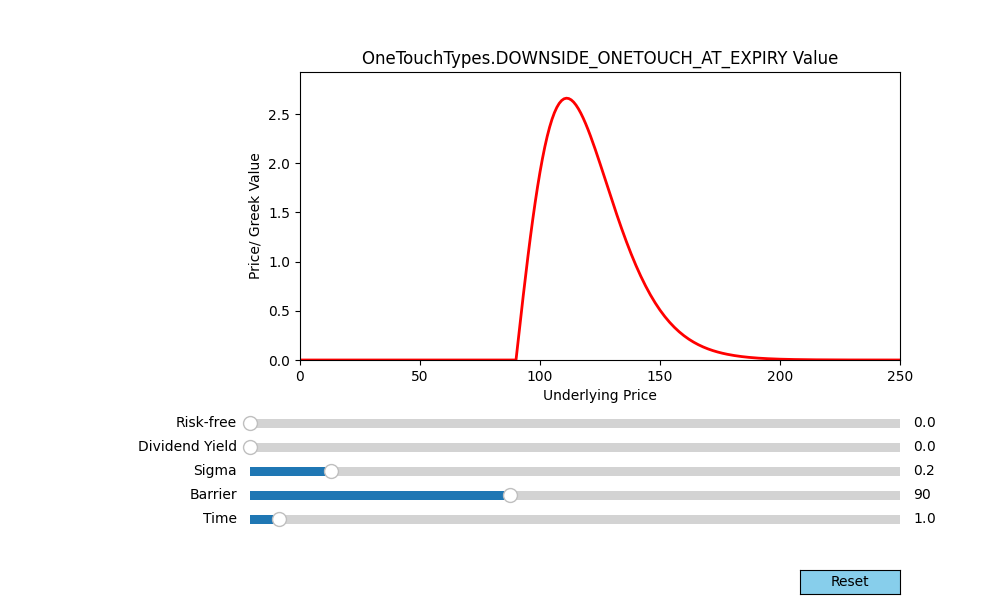

In [18]:
OTPricesandGreeks(OneTouchVega_fd, OneTouchTypes.DOWNSIDE_ONETOUCH_AT_EXPIRY)

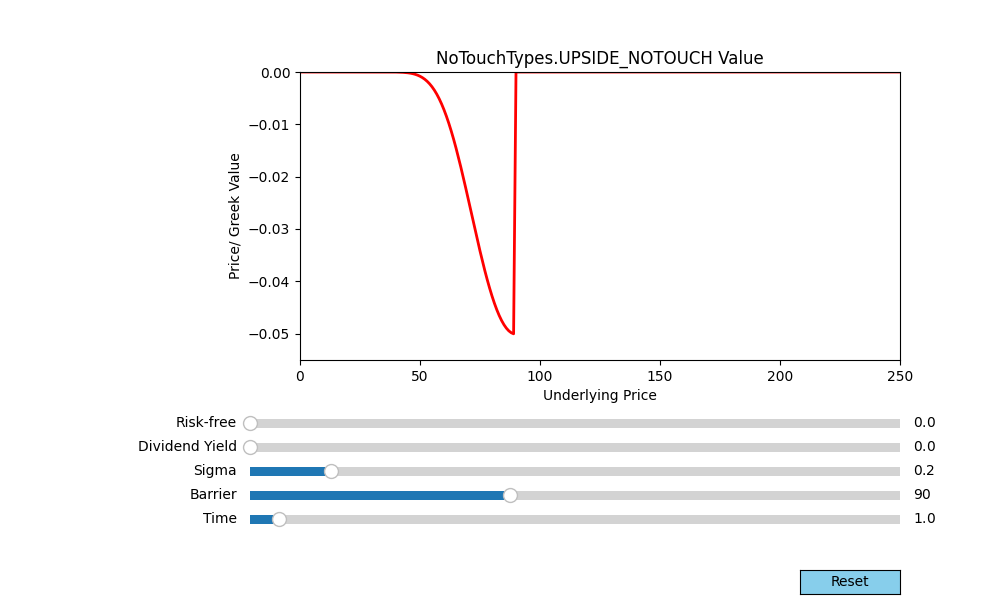

In [19]:
OTPricesandGreeks(NoTouchDelta_fd, NoTouchTypes.UPSIDE_NOTOUCH)

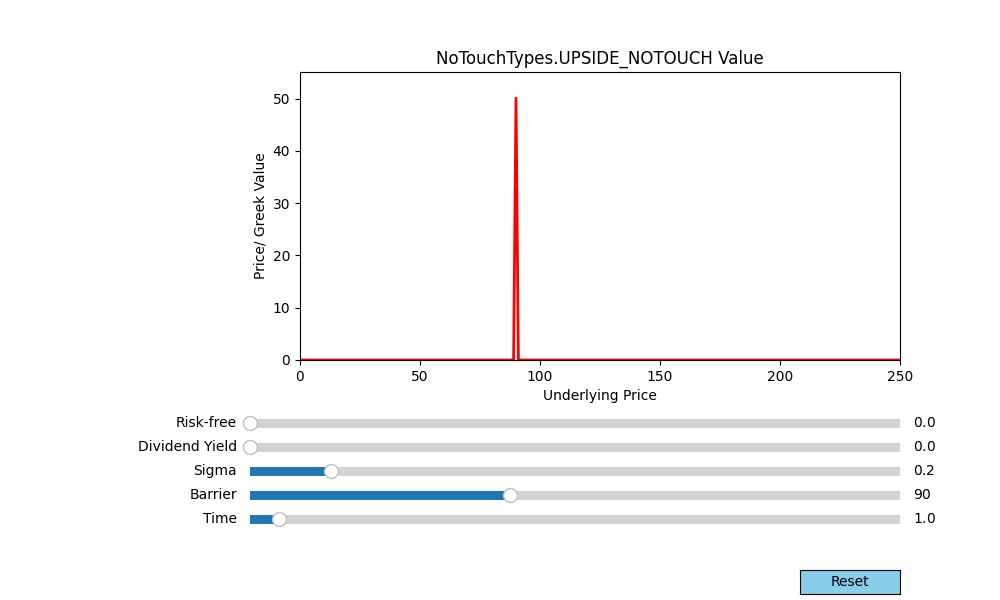

In [20]:
OTPricesandGreeks(NoTouchGamma_fd, NoTouchTypes.UPSIDE_NOTOUCH)

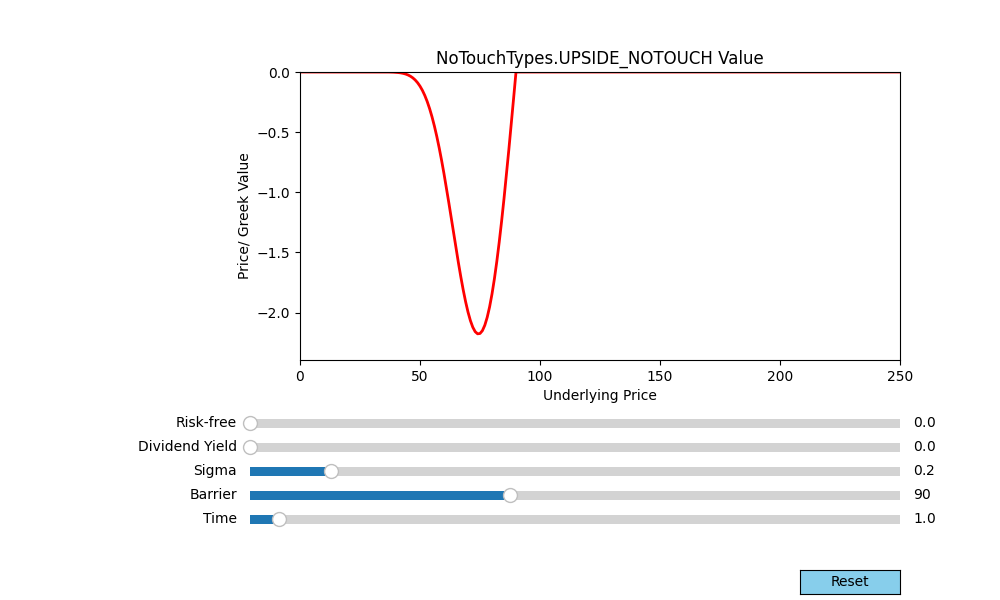

In [21]:
OTPricesandGreeks(NoTouchVega_fd, NoTouchTypes.UPSIDE_NOTOUCH)

# <a id = "p7">7.</a>  <font color = "green"> Charts for Barriers Greeks</font>  [back to table of contents](#top)

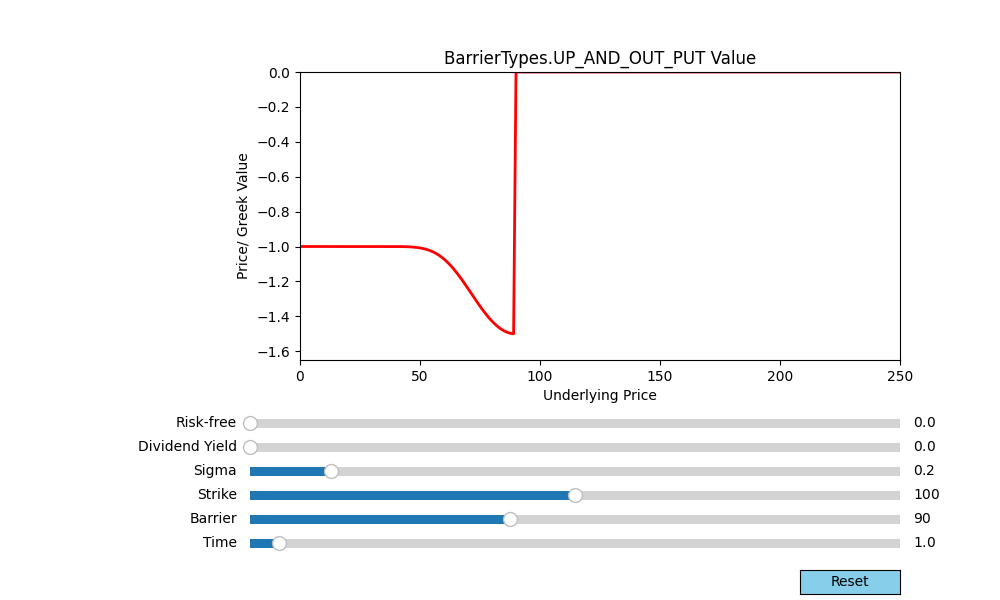

In [22]:
BarrierPricesandGreeks(BarrierOptionDelta_fd, BarrierTypes.UP_AND_OUT_PUT)

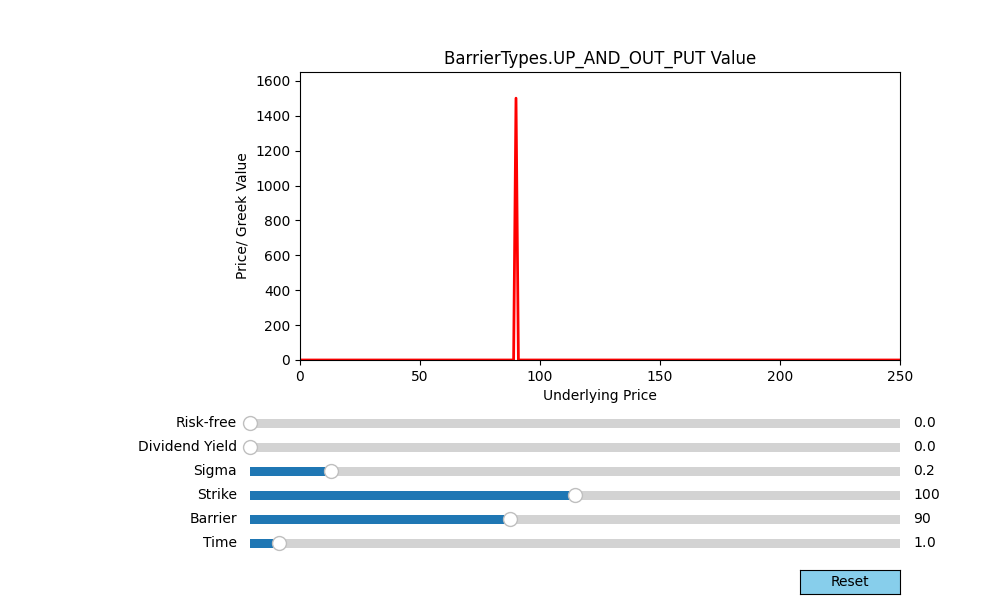

In [23]:
BarrierPricesandGreeks(BarrierOptionGamma_fd, BarrierTypes.UP_AND_OUT_PUT)

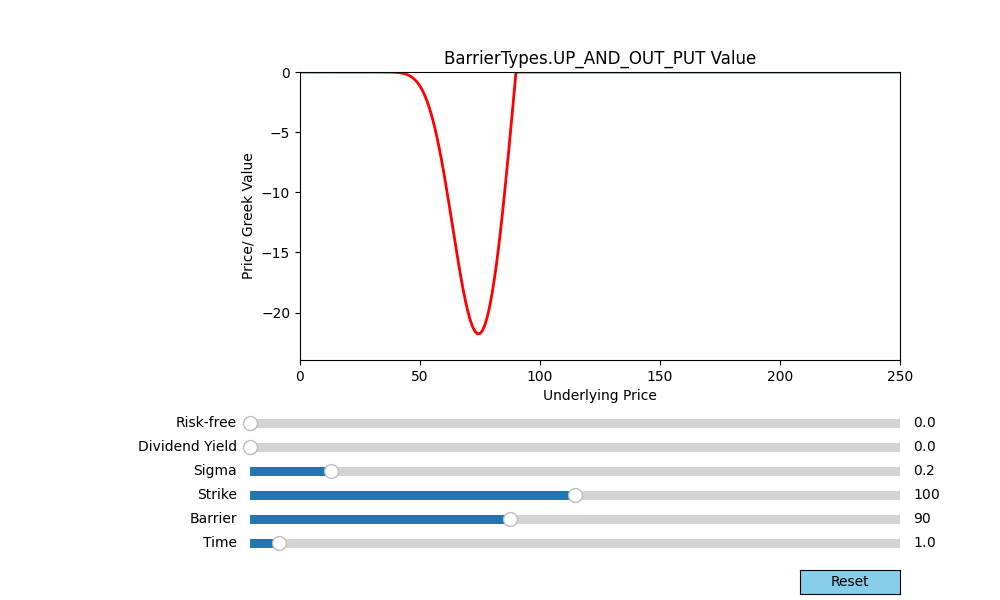

In [24]:
BarrierPricesandGreeks(BarrierOptionVega_fd, BarrierTypes.UP_AND_OUT_PUT)

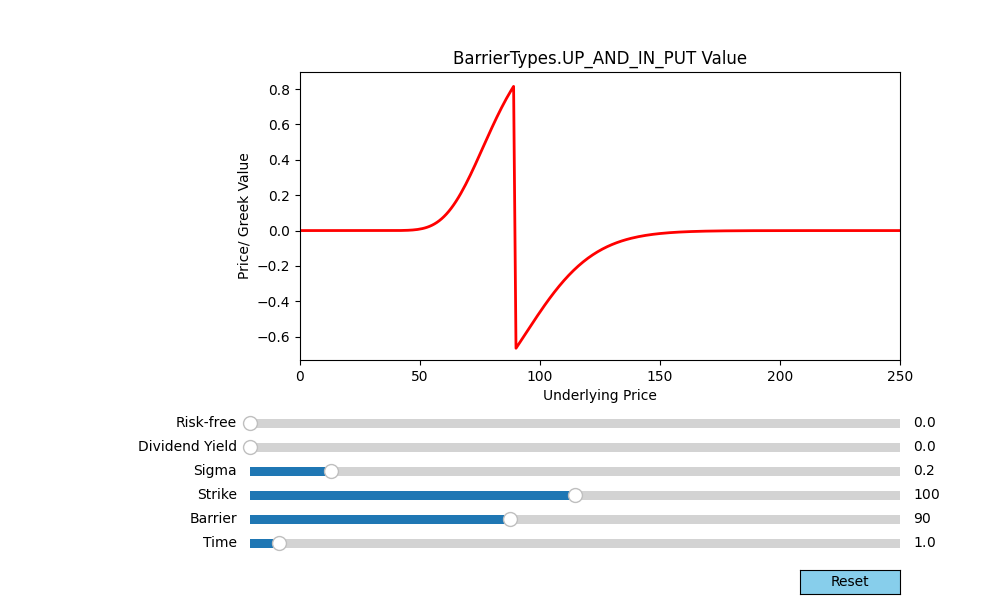

In [25]:
BarrierPricesandGreeks(BarrierOptionDelta_fd, BarrierTypes.UP_AND_IN_PUT)

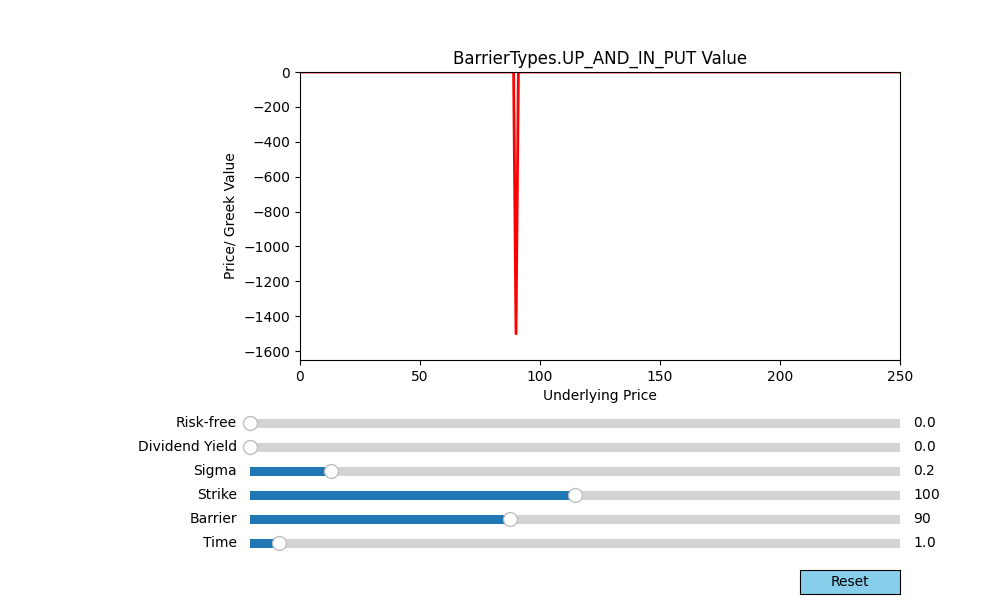

In [26]:
BarrierPricesandGreeks(BarrierOptionGamma_fd, BarrierTypes.UP_AND_IN_PUT)

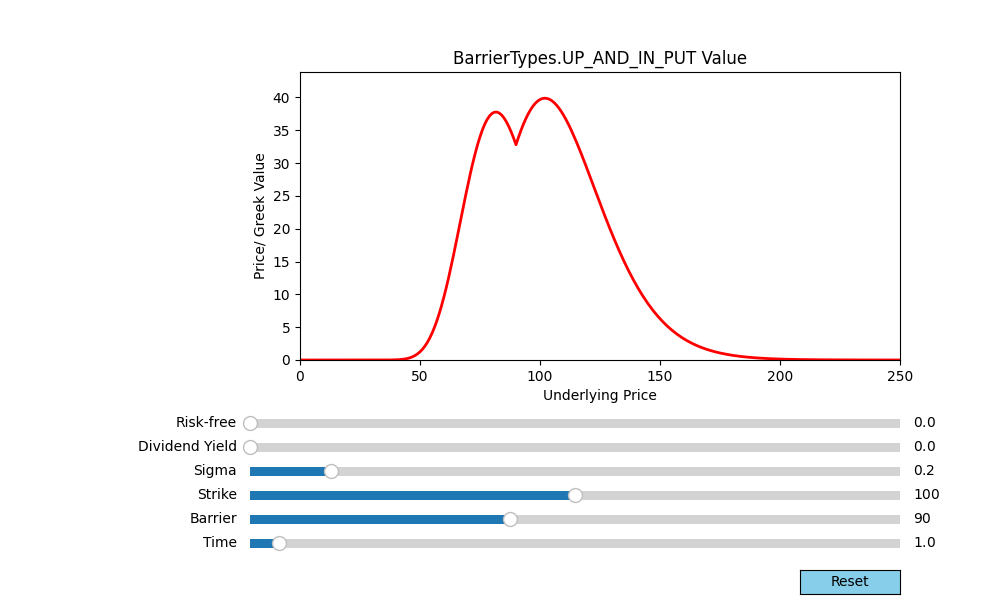

In [27]:
BarrierPricesandGreeks(BarrierOptionVega_fd, BarrierTypes.UP_AND_IN_PUT)